In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

from scipy.stats import norm
from scipy.stats import stats
import pylab

from statsmodels.stats import diagnostic as dia

In [2]:
#all data has been processed
xy = pd.read_csv('loghousecount2.csv')
xy.head()

,AccommodationEatingandDrinking,Attractions,CommercialServices,EducationandHealth,ManufacturingandProduction,PublicInfrastructure,Retail,SportandEntertainment,Transport,simpson,loghousecount,between2km,close2km
0,27,26,125,14,8,23,5,10,11,3.4321,0.5346,4.6893,2.6054
1,41,32,210,16,19,29,12,10,12,2.9837,0.6830,4.1110,2.5145
2,4,4,18,3,3,5,5,4,1,5.0091,0.3888,4.1744,2.5758
3,96,6,267,16,16,30,28,14,23,2.9476,1.1758,4.4815,2.5174
4,0,0,6,2,1,7,0,0,0,2.8444,0.7423,3.5562,2.1194


In [3]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [4]:
xy_vif= drop_column_using_vif_(xy.drop('loghousecount', axis=1))
print("The columns remaining after VIF selection are:")
print(xy_vif.columns)

Dropping: AccommodationEatingandDrinking
Dropping: PublicInfrastructure
The columns remaining after VIF selection are:
Index(['Attractions', 'CommercialServices', 'EducationandHealth',
       'ManufacturingandProduction', 'Retail', 'SportandEntertainment',
       'Transport', 'simpson', 'between2km', 'close2km'],
      dtype='object')


In [5]:
#run OLSmodel
ols_xy_vif = sm.OLS(endog=xy[['loghousecount']], exog=sm.add_constant(xy_vif)).fit()
ols_xy_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          loghousecount   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     103.0
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          2.84e-194
Time:                        13:53:58   Log-Likelihood:                -2494.0
No. Observations:                4835   AIC:                             5010.
Df Residuals:                    4824   BIC:                             5081.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.1349      0.068     -1.974      0.048      -0.269      -0.001
Attractions                   -0.0023      0.001     -1.659      0.097      -0.005       0.000
CommercialServices            -0.0009      0.000     -4.767      0.000      -0.001      -0.001
EducationandHealth             0.0106      0.001     10.909      0.000       0.009       0.013
ManufacturingandProduction     0.0011      0.001      1.575      0.115      -0.000       0.002
Retail                         0.0035      0.000      8.709      0.000       0.003       0.004
SportandEntertainment          0.0079      0.002      3.313      0.001       0.003       0.013
Transport                      0.0044      0.001      3.787      0.000       0.002       0.007
simpson                        0.0071      0.007      1.051      0.293      -0.006       0.020
between2km                     0.1204      0.030      3.996      0.000       0.061       0.179
close2km                       0.2145      0.056      3.823      0.000       0.104       0.324
==============================================================================
Omnibus:                      175.545   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.248
Skew:                          -0.487   Prob(JB):                     6.60e-43
Kurtosis:                       3.125   Cond. No.                         967.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

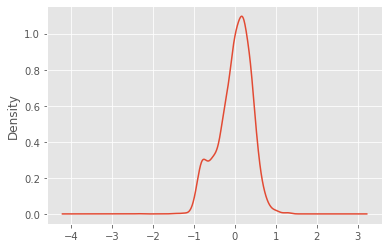

In [6]:
#view residuals
plt.figure()
ols_xy_vif.resid.plot.density()
plt.show()